In [1]:
import tensorflow as tf
from tifffile import TiffFile
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
path = Path(
    "../../../080524/analysis/2024_0805_153629g6actin804-HP-50ms_4x4_4800-2_blue128.tif"
)
path2 = Path(
    "../../../080524/080524-804-2_runrest.csv"
)

In [3]:
with TiffFile(path) as tif:
    a = tif.asarray()
    print(a.shape)

(2400, 128, 128)


In [4]:
b = tf.convert_to_tensor(a, dtype=tf.float32)

In [5]:
dataset = tf.data.Dataset.from_tensors(b)

In [7]:
type(dataset)

tensorflow.python.data.ops.from_tensors_op._TensorDataset

In [8]:
import tensorflow as tf
from pathlib import Path
from tifffile import TiffFile
import gc
import numpy as np
import csv


def load_tiffseq(filename) -> np.ndarray:
    with TiffFile(filename) as tif:
        return tif.asarray()


def min_max(tiffnumpy) -> np.ndarray:
    minvalue = tiffnumpy.min(axis=0)
    maxvalue = tiffnumpy.max(axis=0)

    return np.array(
        [(x - minvalue) / (maxvalue - minvalue) for x in tiffnumpy]
    )


def make_dataset(tiffnumpy) -> tf.data.Dataset:
    tmp_tensor = tf.convert_to_tensor(tiffnumpy, dtype=tf.float32)

    dataset = tf.data.Dataset.from_tensor_slices(tmp_tensor)
    del tmp_tensor
    gc.collect()

    return dataset


def load_runrest(filename) -> np.ndarray:
    with open(filename) as f:
        reader = csv.reader(f)
        labels = [row for row in reader]

    return np.array(labels, dtype=np.uint8)

In [9]:
tiffseq = load_tiffseq(path)

In [10]:
tiffseq_norm = min_max(tiffseq)

In [11]:
dataset = make_dataset(tiffseq)

In [12]:
runrest = load_runrest(path2)

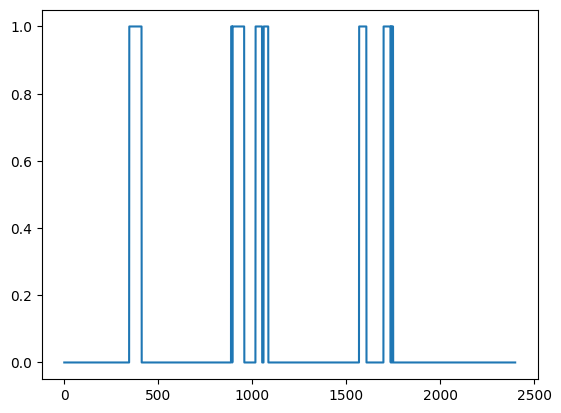

In [13]:
plt.plot(range(0, 2400), runrest.T)


In [14]:
index1 = 300
index2 = 850
index3 = 1000
index4 = 1450
index5 = 1650
slices = 150

In [29]:
len(runrest.T)

2400

In [30]:
dataset1 = make_dataset(tiffseq[index1:index1+slices])
runrest1 = runrest.T[index1:index1+slices]
dataset2 = make_dataset(tiffseq[index2:index2+slices])
runrest2 = runrest.T[index2:index2+slices]
dataset3 = make_dataset(tiffseq[index3:index3+slices])
runrest3 = runrest.T[index3:index3+slices]
dataset4 = make_dataset(tiffseq[index4:index4+slices])
runrest4 = runrest.T[index4:index4+slices]
dataset5 = make_dataset(tiffseq[index5:index5+slices])
runrest5 = runrest.T[index5:index5+slices]

In [35]:
dataset1 = tf.convert_to_tensor(tiffseq[index1:index1+slices])
runrest1 = runrest.T[index1:index1+slices]
dataset2 = tf.convert_to_tensor(tiffseq[index2:index2+slices])
runrest2 = runrest.T[index2:index2+slices]
dataset3 = tf.convert_to_tensor(tiffseq[index3:index3+slices])
runrest3 = runrest.T[index3:index3+slices]
dataset4 = tf.convert_to_tensor(tiffseq[index4:index4+slices])
runrest4 = runrest.T[index4:index4+slices]
dataset5 = tf.convert_to_tensor(tiffseq[index5:index5+slices])
runrest5 = runrest.T[index5:index5+slices]

In [40]:
dataset1 = tiffseq[index1:index1+slices]
runrest1 = runrest.T[index1:index1+slices]
dataset2 = tiffseq[index2:index2+slices]
runrest2 = runrest.T[index2:index2+slices]
dataset3 = tiffseq[index3:index3+slices]
runrest3 = runrest.T[index3:index3+slices]
dataset4 = tiffseq[index4:index4+slices]
runrest4 = runrest.T[index4:index4+slices]
dataset5 = tiffseq[index5:index5+slices]
runrest5 = runrest.T[index5:index5+slices]

In [ ]:
images = dataset1.concatenate(dataset2)
images = images.concatenate(dataset3)
labels = np.concat([runrest1, runrest2, runrest3])
test_images = dataset4.concatenate(dataset4)
test_images = test_images.concatenate(dataset5)
test_labels = np.concat([runrest4, runrest5])

In [41]:
images = np.concat([dataset1, dataset2, dataset3], axis=0)
test_images = np.concat([dataset4, dataset5], axis=0)

labels = np.concat([runrest1, runrest2, runrest3])
test_labels = np.concat([runrest4, runrest5])

In [51]:
labels[300:].mean()

np.float64(0.4)

In [53]:
from tensorflow import keras
from tensorflow.keras import layers

# モデルを作成（後から再利用するために関数として抜き出しておく）
def get_mnist_model():
    inputs = keras.Input(shape=(128*128,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(1, activation="sigmoid")(features)
    model = keras.Model(inputs, outputs)
    return model

# データを読み込み、一部を検証データセットとして確保
images = images.reshape((450, 128*128)).astype("float32")
test_images = test_images.reshape((300, 128*128)).astype("float32")
train_images, val_images = images[150:], images[:150]
train_labels, val_labels = labels[150:], labels[:150]

model = get_mnist_model()
# オプティマイザ、最小化する損失関数、監視する指標を指定した上でモデルをコンパイル
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.summary()

# fit() を使ってモデルを訓練（未知のデータでの性能を監視するために検証データを指定）
model.fit(train_images, train_labels,
          epochs=3,
          validation_data=(val_images, val_labels))

# evaluate() を使って新しいデータでの損失値と指標を計算
test_metrics = model.evaluate(test_images, test_labels)

# predict() を使って新しいデータでの分類確率を計算
predictions = model.predict(test_images)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,389,633 (32.00 MB)

 Trainable params: 8,389,633 (32.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4730 - loss: 25349.1152 - val_accuracy: 0.4400 - val_loss: 3304.4692
Epoch 2/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5359 - loss: 12388.7549 - val_accuracy: 0.5600 - val_loss: 17993.0820
Epoch 3/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5353 - loss: 12695.8037 - val_accuracy: 0.5600 - val_loss: 16101.7197
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8377 - loss: 22.8226    
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [69]:
model.build(input_shape=(None, (128, 128)))

In [72]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [74]:
model(dataset1)

ValueError: Only input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: <_TensorSliceDataset element_spec=TensorSpec(shape=(128, 128), dtype=tf.float32, name=None)> (of type <class 'tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset'>)